In [ ]:
import numpy as np
import scipy
import scipy.special as sp
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from clebschgordan import *
from wigner3j import *
from C_jlp import *
from matplotlib import rc
from mie_coefs import *
from focused_beams_class import *
from domain_class import *
from Multipoles import *




## Define Standard Units
fsize = 22
tsize = 15
tdir = 'in'
major = 5
minor = 3
style = 'default'

params = {
    'figure.figsize': (15,12),
    'savefig.dpi': 75,
    'text.usetex': False,
    'font.size': fsize,
    'legend.fontsize': tsize,
    'legend.title_fontsize': tsize,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral',    
    'axes.labelsize':15,
    'axes.titlesize':20,
    'lines.linewidth':2.5,
    'axes.grid': False,
    'axes.labelweight':'bold',
    'legend.loc': 'upper right',
    'xtick.labelsize':'x-small',
    'ytick.labelsize':'x-small',
}
plt.rcParams.update(params)

In [35]:
import numba
import scipy
import numba_scipy

print("Numba version:", numba.__version__)
print("SciPy version:", scipy.__version__)
print("Numba-Scipy version:", numba_scipy.__version__)

Numba version: 0.61.0
SciPy version: 1.15.1
Numba-Scipy version: 0.2.0


In [40]:
import numba_special


ModuleNotFoundError: No module named 'numba_special'

In [3]:
def d_jmp(j, m, p, Theta):
    M = max(abs(m), abs(p))
    N = min(abs(m), abs(p))
    
    lnCoef = 0.5 * (sp.gammaln(j - M + 1) + sp.gammaln(j + M + 1) - sp.gammaln(j + N + 1) - sp.gammaln(j - N + 1))

    cosFac = np.cos(Theta / 2) ** (abs(m + p))
    sinFac = (np.sin(Theta / 2)) ** (abs(m-p)) ## p-m? 
    
    n = j - M
    alpha = abs(m - p)
    beta = abs(m + p)
    hyp = sp.eval_jacobi(n, alpha, beta, np.cos(Theta))
    
    if hyp == 0:
        d_jmp = 0
    else:
        d_jmp = np.exp(lnCoef) * cosFac * sinFac * hyp * (-1) ** (0.5*(p-m-abs(m-p)))
    
    return d_jmp

\begin{align*}
    D_{m^{\prime}m}^j(\alpha\beta\gamma)=e^{-im^{\prime}\alpha}d_{m^{\prime}m}^j(\beta)e^{-im\gamma}
\end{align*}

In [4]:
def D_jmp(j, m, p, alpha, beta, gamma):
    fac1 = np.exp(-1j * m * alpha)
    fac2 = d_jmp(j, m, p, beta)
    fac3 = np.exp(-1j * p * gamma)
    return fac1 * fac2 * fac3

In [24]:
#initialize domain
size = 4
planes = {'xy', 'xz', 'yz'}
d = domain(size, planes)

wl = 0.632
jmax = 10

foc = focused_beams("LaguerreGauss", jmax, wl, d, NA=0.9, f=1000, n_lens=1)

The (2j+1)Cjm_z normalization yields 1.996314
The LG integral on the aplanatic lens surface is 0.998



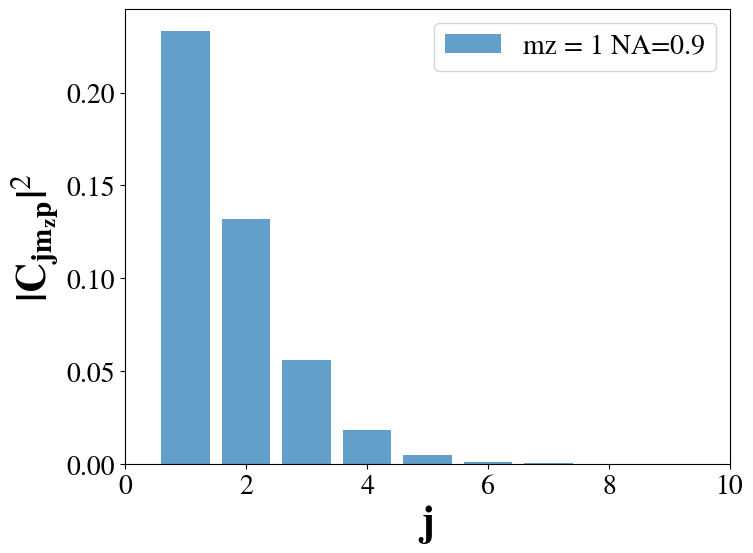

In [25]:
C_on = foc.C_jlp(l = 0, p = 1, q = 0)
foc.plot_Cjl(l = 0, p = 1, q = 0)

In [26]:
#@njit
def process_d(d):
    """ 
    Decompose d into a magnitude and two rotation angles: 
        polar (theta) and azimuthal (phi)
    Parameters:
        d: numpy array of shape (3,) specifying the cartesian coordinates
    Returns:
        d: float: magnitude of d
        theta: float: polar angle in radians
        phi: float: azimuthal angle in radians
    """
    # Check if d is a numpy array
    if not isinstance(d, np.ndarray):
        d = np.array(d)
    # Check if d has the correct shape
    if d.shape != (3,):
        raise ValueError("Input array must have shape (3,)")
    if np.linalg.norm(d) == 0:
        print("displacement is zero")
        return 0, 0, 0
    else:
        mag = np.linalg.norm(d)
        d = d / mag # normalize
        # Calculate the angles
        theta = np.arccos(d[2])
        phi = np.arctan2(d[1], d[0])
        
        return mag, theta, phi       

In [27]:
d = np.array([0, 4, 0])
m, theta, phi = process_d(d)
print(m, theta, phi)

4.0 1.5707963267948966 1.5707963267948966


In [28]:
D_jmp(4, -1, 1, theta, phi, 0)

(-2.2962127484012877e-17-0.37500000000000006j)

\begin{align*}
    C_{j,m_z,p}^{off,\mathbf{d}} = \sum_{n=-\min (j, j^{\prime})}^{\min (j, j^{\prime})} \sum_{L=0}^\infty
    (2L+1)(-i)^L j_L(kd) \times
    \braket{j, n; L,0|j^\prime,n}\braket{j, p; L,0|j^\prime,p}
    \sum_{j^\prime=m_z^*}^\infty D^j_{m_z n}(\mathrm{\hat{d}})D^j_{m_z^* n}(\mathrm{\hat{d}}) C_{j^\prime m_z^* p}^{on}
\end{align*}

If the displacement is along z:
\begin{align*}
    C_{j,m_z,p}^{off,\mathbf{d}} =  \sum_{j^\prime=m_z^*}^\infty C_{j^\prime m_z^* p}^{on} \sum_{L=0}^\infty
    (2L+1)(-i)^L j_L(kd) \times
    \braket{j, n; L,0|j^\prime,n}\braket{j, p; L,0|j^\prime,p}
\end{align*}

In [29]:
def get_Jl(L, x):
    return sp.spherical_jn(L, x)

In [41]:
#@jit(nopython=True)
def compute_C_off(j_max, mz_star, p, k, d, C_on):
    """
    Compute C^off as a 2D array with:
    - j from 0 to j_max (axis 1)
    - m_z from -j_max to j_max (axis 2)

    Parameters:
    - j_max: Maximum j value
    - mz_star: Fixed m_z* value
    - p: Index p
    - k: Wavevector magnitude
    - d: Displacement vector (numpy array with shape (3,))
    - C_on: Known C^on values (1D array, indexed by j')

    Returns:
    - C_off: 2D array of shape (j_max+1, 2*j_max+1)
    """
    C_off = np.zeros((j_max + 1, 2 * j_max + 1), dtype=np.complex128)  # Initialize C_off array
    
    # Process the displacement vector into spherical coordinates
    mag, theta, phi = process_d(d)
    
    Lvals = np.arange(0, 2* j_max + 1)
    #simple case: z displacemet
    if ((d[0] == 0) and (d[1] == 0)):
        for j in range(j_max + 1):
            for m_z in range(-j_max, j_max + 1):
                sum_Ln = 0
                for L in Lvals:
                    J_L = get_Jl(L, k * mag)
                    factor = (2 * L + 1) * (-1j)**L * J_L
                    CG_1 = clebsch_gordan(j, L, j_prime, mz_star, 0, mz_star)
                    CG_2 = clebsch_gordan(j, L, j_prime, p, 0, p)
                    sum_Ln += factor * CG_1 * CG_2

                # Store result in 2D array, shifting index for m_z
                C_off[j, m_z + j_max] += sum_Ln * C_on[j_prime]
    else:       
        for j in range(j_max + 1):
            for m_z in range(-j_max, j_max + 1):
                for j_prime in range(mz_star, j_max + 1):
                    sum_Ln = 0
                    for L in Lvals:
                        J_L = get_Jl(L, k * mag)
                        factor = (2 * L + 1) * (-1j)**L * J_L
                        for n in range(-min(j, j_prime), min(j, j_prime) + 1):
                            CG_1 = clebsch_gordan(j, L, j_prime, n, 0, n)
                            CG_2 = clebsch_gordan(j, L, j_prime, p, 0, p)
                            D1 = D_jmp(j_prime, mz_star, n, phi, theta, 0) 
                            D2 = D_jmp(j, m_z, n, phi, theta, 0)
                            sum_Ln += factor * CG_1 * CG_2 * D1 * D2
                            
                        if sum_Ln != 0:    
                            pass
                            #print("sum_Ln", sum_Ln)

                    C_off[j, m_z + j_max] += C_on[j_prime] * sum_Ln

    return C_off


In [ ]:
d = np.array([0, 0.3, 0]) #displacement along y

k = 2*np.pi / wl
l = 0; p = 1; q = 0
mz_star = l+p
C_on = foc.C_jlp(l, p, q)[0]
C_off = compute_C_off(jmax, mz_star, p, k, d, C_on)

C_off = C_off.sum(axis=1)  # Sum over m_z to get C_off for each j

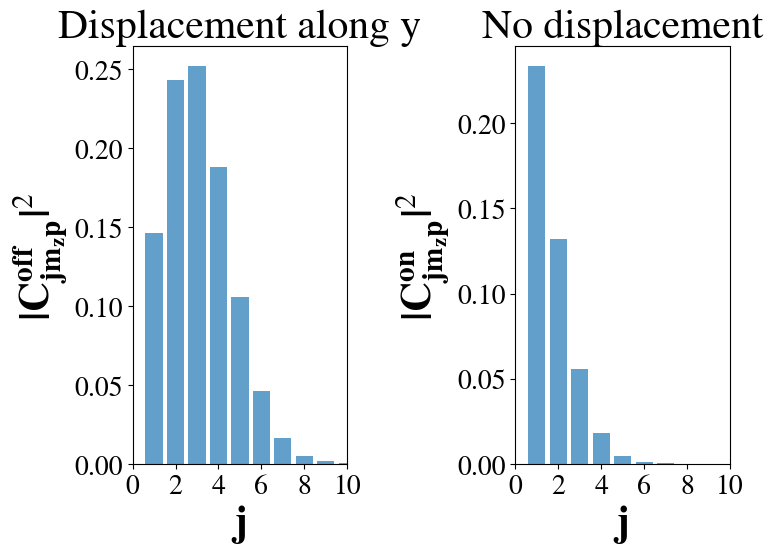

In [39]:
#plot C_off
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].bar(np.arange(0, len(C_off)), np.abs(C_off)**2, alpha=0.7)
ax[0].set_ylabel(r"$\mathbf{|C^{off}_{jm_zp}|}^2$", fontsize=30)
ax[0].set_xlabel('j', fontsize=30)
ax[0].set_xlim(0, jmax)
ax[0].set_xticks(range(0, jmax + 1, 2))  # Set x-ticks to increase in steps of 2
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_title("Displacement along y", fontsize=30)
ax[1].bar(np.arange(0, len(C_off)), np.abs(foc.C_jlp(l = 0, p = 1, q = 0)[0])**2, alpha=0.7)
ax[1].set_ylabel(r"$\mathbf{|C^{on}_{jm_zp}|}^2$", fontsize=30)
ax[1].set_xlabel('j', fontsize=30)
ax[1].set_xlim(0, jmax)
ax[1].set_xticks(range(0, jmax + 1, 2))  # Set x-ticks to increase in steps of 2
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_title("No displacement", fontsize=30)

fig.tight_layout()
plt.show()

In [ ]:
C_off.shape

(11,)

In [ ]:
print(C_off)

[0.00000000e+000+0.00000000e+000j 1.52065852e-011-2.08285417e-011j
 3.46145870e-027-5.53529528e-027j 5.25646814e-043-9.07318419e-043j
 5.98209498e-059-1.07836359e-058j 5.43584310e-075-1.00734253e-074j
 4.10735253e-091-7.75701866e-091j 2.65468507e-107-5.08259447e-107j
 1.49850680e-123-2.89863889e-123j 7.50635578e-140-1.46359940e-139j
 3.37912146e-156-6.63043616e-156j]
